# Read in cleaned data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/STAT 190/Data/2024_5-5-2025.csv")
db = data.drop(columns=['houseHoldIdAfn', 'annualIncome'])
df = db
db.head(1)

Mounted at /content/drive/


,fedPovertyLevel,location,education_count,race_family,category_family,household_size,percent_male,income_bin,months_visited,12_visits,>6_visits,family_veteran,family_foodstamps,family_dietaryIssue
0,0,DMARC-ket Southside Food Pantry,0,White,Unemployed No Income,1,0.0,0,1,0,0,No,Yes,False


# Fit a logistic regression

## Preparing Data


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define predictor and target
X = df.drop(columns=['12_visits', 'months_visited', '>6_visits'])
y = df['12_visits']

# Define preprocessor
categorical_features = ['location', 'race_family', 'category_family', 'income_bin']
numerical_features = ['fedPovertyLevel', 'education_count', 'household_size', 'percent_male']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Model Creation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])
# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

## Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,  roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6881638846737481
ROC-AUC: 0.7466289246354594

Confusion Matrix:
 [[3999 1937]
 [ 118  536]]


# Coefficient Interpretations

In [ ]:
# Get the logistic regression classifier from the pipeline
logreg = model.named_steps['classifier']

# Get feature names after preprocessing
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame of coefficients and feature names
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logreg.coef_[0]  # Coefficients are stored in a 2D array
})

# Sort by absolute coefficient value (importance)
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Absolute_Coefficient', ascending=False)

print(coef_df)

                                              Feature  Coefficient  \
45                      cat__income_bin_25,800-87,000     1.732512   
44                      cat__income_bin_14,000-25,800     1.638465   
22       cat__location_West Des Moines Human Services     1.356781   
32            cat__category_family_Don't Know/Unknown    -1.328440   
29                           cat__race_family_Unknown    -1.250687   
43                           cat__income_bin_1-14,000     1.174129   
26                             cat__race_family_Mixed     1.079211   
39  cat__category_family_Stay at Home Parent/Careg...     1.053558   
38       cat__category_family_Retired/Social Security     1.032514   
23                             cat__race_family_Asian     1.021907   
1   cat__location_Affiliate - Dallas Center Food P...    -1.002296   
30                             cat__race_family_White     0.944876   
33  cat__category_family_FIP (Family Investment Pr...    -0.836734   
2         cat__locat

#Visualize importance

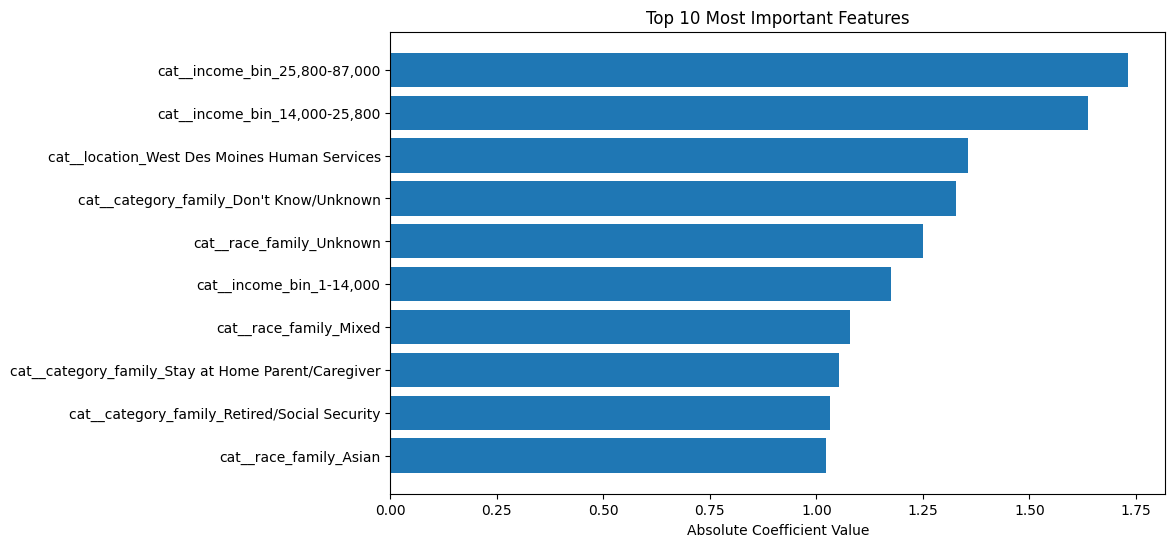

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:10], coef_df['Absolute_Coefficient'][:10])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Show largest at top
plt.show()

In [ ]:
# Access the OneHotEncoder from the pipeline
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat']

# Get sorted categories for each categorical feature
categories = cat_encoder.categories_

# Example for 'location' (first categorical feature)
location_categories = categories[0]
reference_group_location = location_categories[0]  # First category is dropped
categorical_features = ['location', 'race_family', 'category_family', 'income_bin']

# Reference groups for each feature:
reference_groups = {
    'location': categories[0][0],
    'race_family': categories[1][0],
    'category_family': categories[2][0],
    'income_bin': categories[3][0]
}

print(reference_groups)

{'location': 'Adel Good Samaritan Food Pantry', 'race_family': 'American Indian/Alaskan Native', 'category_family': 'Child Support', 'income_bin': '0'}
